# 2 Solving the RFA problem using FEM

Before starting with the FEniCS code, we will present a short theoretical introduction. The simulation of RFA in the atrial wall involves two main physical coupled problems modeled by the electric equation and the bioheat equation, which are briefly introduced. Thermal damage is evaluated by considering the Arrhenius equation, which is also commented. The structure of this section of the tutorial is as follows: first the theory, then the strategy of the numerical solution and finally the code.

## 2.1 Theory

### 2.1.1 The electric equation

In RFA the heat ($q_{RF}$) is generated by the Joule effect, applying an electrical current to the desired region. This heat depends on the electric conductivity ($\sigma$) and the electric field ($E$) and is given by the equation $q_{\text{RF}}=\sigma \left| E\right|^{2}$. The electric field is defined as $E=-\nabla V$, where $V$ is the voltage. The latter is computed by solving the so-called Poisson equation in the desired volume (domain) $\Omega$:

$$\begin{equation} \nabla \cdot \left(\sigma \nabla V \right) = 0.\end{equation}\tag{1}$$


Electrical conductivity can be a function of the position and the temperature. Eq. (1) is a __*partial differential equation*__ (PDE) and can be solved if the __*boundary conditions*__ are known, in our case (remember the section of mesh generation) we have set:

- $V = 50$ V in the tagged with 2 (Physical Line(2) = {1,2,4}; // active electrode (metal)).
- $V = 0$ V in the tagged with 3 (Physical Line(3) = {11,12}; // passive electrode, V = 0).

These are Dirichlet boundary conditions. The domains of the boundary conditions will be called $\Gamma$, in particular for a Dirichlet boundary condition $\Gamma_{\text{D}}$.

### 2.1.2 The bioheat equation

The temperature $T$ is obtained by solving the governing PDE for the thermal problem, which is the bioheat equation (without accounting for the vaporization phenomenon):

$$\begin{equation} \rho c \frac{\partial T}{\partial t} = \nabla \cdot \left( k \nabla T\right) +q_{\text{RF}} +\beta \rho_{\text{b}}c_{\text{b}}\omega_{\text{b}}\left(T_{\text{b}}-T\right)+Q_{\text{met}}\end{equation}\tag{2}$$

where $k$ is thermal conductivity, $\rho$ is density, $c$ is specific heat, $\omega$ is perfusion. $Q_{\text{met}}=0$ (metabolic heat) is set because it is negligible in RFA. The parameter $\beta$ is a coefficient which takes the values of 0 and 1, according to the value of the thermal damage (we will explain this later). The mentioned parameters can be functions of position and temperature. Subscript b indicates that they are blood parameters.

The __*boundary conditions*__ of Eq. (2) are:

- $T = 37 ^{\text{ o}}\text{C}$ in the tagged with 3 and 4 (Physical Line(3) = {11,12}; // passive electrode, U = 0 V and 37 deg and Physical Line(4) = {8,17,18}; // I = 0 A and 37 deg).
- $T = 40 ^{\text{ o}}\text{C}$ in the tagged with 5 (Physical Line(5) = {3}; // perfusion constant temperature 40 deg). This simulates an irrigated electrode perfused with saline solution at $40 ^{\text{ o}}\text{C}$.

These are also Dirichlet conditions. The thermal effect of the circulating blood in the cardiac chamber (assuming high flow) can be modeled by thermal transfer coefficients between blood and tissue ($h_{\text{t}} = 610 \; \text{W}/\text{m}^{2} \text{K}$) and between blood and electrode ($h_{\text{e}} = 3346 \; \text{W}/\text{m}^{2} \text{K}$). They are known as Robin boundary conditions and are expressed as: $-\frac{\partial T}{\partial n}=h_{\text{i}}\left( T - T_{\text{b}}\right)$, for $\text{i}=\text{t},\text{e}$ where $n$ is the unit vector which points in the normal direction of the boundary (line in 2D or surface in 3D). We set this condition to the lines tagged with 6 and 7, respectively (*Physical Line(6) = {16}; // convective heat loss (plastic) Physical Line(7) = {7}; // convective heat loss (tissue)*).

In the case of Robin and Neumman boundary conditions we will call them $\Gamma_{\text{R}}$ and $\Gamma_{\text{N}}$, respectively.
As this problem is a transient heat equation, the initial condition is also needed: 

$$T\left(x,y, t = 0 \; \text{s}\right) = 37 ^{\text{ o}}\text{C},$$

we make implicit here the dependence on position and time.

### 2.1.3 The thermal damage

The Arrhenius damage model associates temperature with exposure time by a first‐order kinetics relationship:

$$\begin{equation} D\left(t\right) = \int_{0}^{t} Ae^{-\frac{\Delta E}{RT}} d\tau \end{equation} \tag{3},$$

where $A$ and $\Delta E$ are a frequency factor and the activation energy for the irreversible damage reaction, respectively. $R$ is the universal gas constant. We assess the thermal damage by the D99 isoline, which is $D= 4.6$ (99% probability of cell death). This means that when the value of $D=4.6$ we change the value of $\beta$ to zero, then the blood perfusion term of the bioheat equation is null. The location of the D99 isoline defines the size of the coagulation zone. For the purpose of this tutorial we express Eq. (3) as an ordinary differential equation (ODE): 

$$\frac{dD}{dt}=Ae^{-\frac{\Delta E}{RT\left(t\right)}}\tag{4}.$$

Note that we make explicit the dependence of the temperature on time ($T\left(t\right)$) in order to show that it results in a non-linear ODE that should be numerically solved in each time step.

### 2.1.4 The variational form

The starting point of FE methods is to express the PDE in *variational form* in order to solve the weak problem. For example, if we work with Eq. (1) (slightly modified to generalize the reasoning, that is, $-\nabla \cdot \left(\sigma \nabla V \right) = f$, where $f$ is a known source), first we have to multiply the PDE by a function $v$ (__*test function*__) and integrate the resulting equation in the domain $\Omega$. 

$$-\nabla \cdot \left(\sigma \nabla V \right) = f \Rightarrow -\int_{\Omega}\nabla \cdot \left(\sigma \nabla V \right)\; v\; \text{dx} = \int_{\Omega} f \; v \; \text{dx}.$$

We denote here $\text{dx}$ as the differential of the domain $\Omega$ in this example: $\text{dx}=dxdy$. Note that the left part of Eq. (1) has second-order derivatives. Solving PDEs by FEM requires integration by parts in order to obtain first-order derivatives only. This is obtained by applying Green’s Formula. 

$$-\int_{\Omega}\nabla \cdot \left(\sigma \nabla V \right)\; v\; \text{dx} = \int_{\Omega} \sigma\nabla V \cdot \nabla v \;\text{dx} - \int_{\Gamma} \sigma \; n\cdot \nabla V \;v \;\text{ds}.\tag{5}$$

The term $n\cdot\nabla V$ is the derivative of $V$ in the outward normal direction $n$ on the respective boundary and is denoted as $\frac{\partial V}{\partial n}$. The differential $\text{ds}$ is defined on the boundary domain $\Gamma$. Reordering Eq. (5): 

$$\int_{\Omega} \sigma \nabla  V \cdot \nabla v \;\text{dx} = \int_{\Omega} f \; v \; \text{dx}-\int_{\Gamma} \sigma \; \frac{\partial V}{\partial n} \;v \;\text{ds}.\tag{6}$$

In our electrical problem, as there are only Dirichlet boundary conditions and $v$ can be made to vanish on the boundaries, the second term on the right hand of Eq. (6) also vanishes: 

$$\int_{\Omega} \sigma \nabla  V \cdot \nabla v \;\text{dx} = \int_{\Omega} f \; v \; \text{dx}.\tag{7}$$

The left hand of this equation is called the __*bilinear form*__ and the right hand the __*linear form*__ and are usually denoted by: $a\left(V,v\right)$ and $L\left(v\right)$, respectively. Note that the $a$ is function of both $V$ and $v$, and $L$ is only a function of $v$ (because $f$ is the known source).
In the case of the bioheat equation the procedure is similar, with the addition of the Robin boundary conditions (convective). They are modeled as $-k\frac{\partial T}{\partial n}=h\left( T - T_{\text{b}}\right)$. This condition is then written as: 

$$-\int_{\Gamma_{\text{R}}} k \; \frac{\partial T}{\partial n} \;v \;\text{ds} = \int_{\Gamma_{\text{R}}} \; h\left( T - T_{\text{b}}\right)  \;v \;\text{ds}\tag{8}$$

Eqs. (6-8) are written in FEniCS in a very similar way, for example Eq. (7) is coded as:

In [ ]:
a = sigma*inner(nabla_grad(V), nabla_grad(v))*dx
L = f*v*dx

and to solve it the code is:

In [ ]:
solve(a == L, V, bcs)

This code is read as: make *a* equal to *L* with the boundary conditions *bcs* and save the result in variable *V*.



## 2.2 Numerical strategy

It should be underlined that we have to solve three coupled equations: two PDEs and one ODE. We need to discretize these in space and time. In this section we comment on time discretization.

### 2.2.1 General approach

Note that Eq. (1) is an electric quasi‐static approach, which is used since the resistive current is much lower than the displacement current at RF. Equation (1) is only related to Eq. (2) by the dependence of electrical conductivity on $T$ ($\sigma \left(T\right)$). Therefore, one approach is to solve Eq. (1) with a known temperature by considering a constant electrical conductivity at this particular temperature, i.e. piecewise constant within the time step, starting from body temperature ($37 ^{\text{ o}}\text{C}$). In this way the voltage is uncoupled from the temperature, considered as a weak coupling. The general approach can be outlined by the following __*steps*__:

1. Initialize temperature of the geometry.
2. With known temperatures solve Eq. (1) to obtain $q_{\text{RF}}$.
3. With known $q_{\text{RF}}$ solve Eq. (2).
4. With known temperature integrate Eq. (4).
5. Go to step 2 and repeat.

### 2.2.2 Time discretisation scheme

Eq. (2) depends on time and can be solved by a simple backward Euler approach. The first derivative is approached by: 

$$\begin{equation}\left(\frac{\partial T}{\partial t}\right)^{\left(n+1\right)}\approx \frac{T^{\left(n+1\right)}-T^{\left(n\right)}}{\Delta t} \end{equation},\tag{9}$$

where the superscript $\left(n\right)$ indicates the time step $n$. The first step is known, because we have the initial condition $T\left(x,y, t = 0 \; \text{s}\right) = 37 ^{\text{ o}}\text{C}$.

### 2.2.3 Dependence of the parameters on temperature

For the sake of clarity in the example in this tutorial we consider two parameters which depend on temperature: electrical and thermal conductivities. We model the conductivity with a linear dependence on temperature. For example, the electric conductivity is: $\sigma\left( T\right)= \sigma\left(T_{0}\right)\cdot \left( 1+\frac{\Delta \sigma}{\sigma\left(T_{0}\right)} \cdot \left(T-T_{0}\right)\right)$.

## 2.3 Some coding

The first line in the program should be:

In [ ]:
from fenics import *

with this sentence we import all the FEniCS functions. As the mesh has already been created in the previous tutorial, we can create the finite element __function space__ $\Omega$ where all the variables will "live". In the program  we will call it *W*.

In [ ]:
W = FunctionSpace(mesh, 'CG', 2)

Here, "CG" stands for Continuous Galerkin, involving the standard Lagrange family of elements, in this case with degree 2 (go to this [link](http://femtable.org/) to see the notation).

Then, to initialize the temperature in the whole mesh we write:

In [ ]:
T_initial = Constant(310.15)
T = project_axisym(T_initial,W)

Note that we express the temperature in Kelvin and use the function *Constant*, which indicates to FEniCS that this is a constant. We create a function *project_axisym* to solve the problem axisymmetric ally, with the main axis the vertical center of the electrode. As a result the reader will see that most of the terms will be multiplied by *r* (distance to the axis of symmetry), which is defined as:

In [ ]:
r = Expression('x[0]',degree=2)#Define the radius for axisymetric problem

In Section 2.2.1 we sketch the algorithm and mention that the electrical problem and the bioheat equation are weakly coupled, then define two main functions: *electric_problem* and *rfa_bioheat_problem*.

### 2.3.1 Function *electric_problem*

We describe this function to show the general form of an FEniCS code.

The *electric_problem* function has the following inputs: problemname, mesh, interior, boundaries, emp, Theta, and thp.

- problemname: is the name of the .geo file in our example: 'rfa-atrial-wall'
- mesh: is the mesh loaded to FEniCS by 'mesh = Mesh(problemname+".xml")', see [Section 1.3 Mesh generation](https://github.com/rirastorza/RFA-tutorial/blob/master/mesh%20generation/meshgenration.ipynb)
- interior: are the subdomains loaded by 'interior = MeshFunction("size_t", mesh, problemname+"_physical_region.xml")'
- boundaries: are the boundaries loaded by 'boundaries = MeshFunction("size_t", mesh, problemname+"_facet_region.xml")'
- emp: is the class in which all the electrical parameters are loaded.
- Theta: is the increment $\Delta T = T-T_{0}$ of the temperature computed in the previous step, or zero for the initial step.
- thp: is the class in which all the thermal parameters are loaded.

The outputs are:

- qRF: generated heat by the Joule effect of the geometry.
- resistance: impedance of the entire domain.
- power: power of the entire domain.
- U: voltage of the geometry.

#### Structure of the function

We describe some of the main parts of the function. The complete code is in [Section 3) Runing a simulation](https://github.com/rirastorza/RFA-tutorial/blob/master/run/coding.ipynb).

The Dirichlet boundary conditions are loaded as follows:

In [ ]:
bcs = []
bcs.append(DirichletBC(W, emp.Vprobe, boundaries, 2))#Active electrode
bcs.append(DirichletBC(W, emp.Vprobe, boundaries, 5))#Active electrode at 40 Deg
bcs.append(DirichletBC(W, emp.V0, boundaries, 3))#Passive electrode

Note that this is defined as a python list to which the Dirichlet boundary conditions are appended. Only Dirichlet type can be defined in this step, later we will show how to define Robin and Neumman type conditions.

The defintion of the electric conductivity map is as follows:

In [ ]:
class MATERIAL(UserExpression):
        def __init__(self, subdomains,s_1,s_2,s_3, s_4,**kwargs):
            super().__init__(**kwargs)
            self.subdomains = subdomains
            self.s_1 = s_1
            self.s_2 = s_2        
            self.s_3 = s_3
            self.s_4 = s_4        
        def eval_cell(self, values, x, cell):
            if self.subdomains[cell.index] == 1:
                values[0] = self.s_1#Atrial wall
            elif self.subdomains[cell.index] == 2:
                values[0] = self.s_2#Connective tissue
            elif self.subdomains[cell.index] == 3:
                values[0] = self.s_3#Plastic
            else:
                values[0] = self.s_4#Blood

Note that this class is derived from the *UserExpression* class and the inputs are: the *subdomains* (with the tags that mark each region), the *temperature* map (which is updated in each time step) and the parameters at $37 ^{\text{ o}}\text{C}$ within each subdomain *s_1*, *s_2*, *s_3*, and *s_4* (we have to previously define them as constants). Then we call this class as follows:

In [ ]:
#Diferent baseline conductivities
conductivities = [0.28, 0.2, 1e-5 , 0.667]   
s_1 = conductivities[0] #Atrial wall
s_2 = conductivities[1] #Connective tissue
s_3 = conductivities[2] #Plastic
s_4 = conductivities[3] #Blood
    
SIGMA = MATERIAL(interior,s_1,s_2,s_3, s_4,degree=0)

The degree = 0 indicates that it is a scalar function.

We also remark that the electrical conductivities that depend on the temperature are the atrial wall and the connective tissue. This can be done by multiplying the variable *SIGMA* with the function $\left(1+\frac{\Delta \sigma}{\sigma_{0}}\left(T-T_{0}\right)\right)$:

In [ ]:
sigma = (1.0 + cond_rate*(T_p))*SIGMA

To check if values have been set in the right way:

In [ ]:
File("outputs/sigma.pvd") << project_axisym(SIGMA,W)

The previous sentence creates the fold *outputs* and saves the function of space (sigma) in a file called sigma.pvd, which can be visualized by Paraview.

![figure1.png](attachment:figure1.png "Conductivity map")
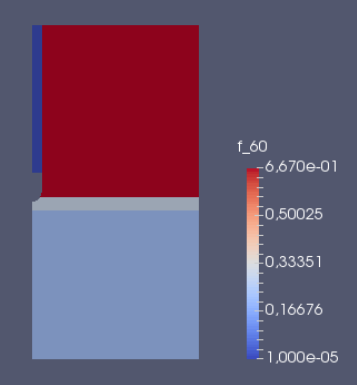

Then we define two functions that "live" in the space $\Omega$ (called W in the program):

In [ ]:
V = TrialFunction(W)
v = TestFunction(W)

These are the trial function and the test function ($v$). The trial function is taken as a symbolic variable (it is the unknown function). Therefore we can now define the variational form:

In [ ]:
a = sigma*inner(nabla_grad(V), nabla_grad(v))*r*dx
L = source*v*r*dx

We emphasize that the formulas in the variational formulation translate directly to very similar Python code. The language used to express weak forms is called UFL (Unified Form Language) and is an integral part of FEniCS. Now, to compute the voltage we first have to convert the *trial function V* into *function* in order to indicate to FEniCS that it should be numerically solved.

In [ ]:
V = Function(W)
solve(a == L, V, bcs)
File("outputs/voltage.pvd") << V

Plotted with Paraview it gives:

![figure2.png](attachment:figure2.png "Voltage")
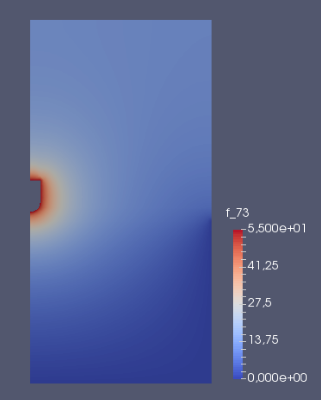

As we are interested in computing the heat generated by RF, then the quantity needed is the $q_{\text{RF}}$. We also make this computation by FEM , by $q_{\text{RF}}=\sigma \nabla V \cdot \nabla V$.

In [ ]:
v = TestFunction(W)
qRF = TrialFunction(W)
a = qRF*v*r*dx
L = v*sigma*inner(nabla_grad(V), nabla_grad(V))*r*dx
qRF = Function(W)
solve(a == L, qRF)

The $q_{\text{RF}}$ will be used as input for the function *rfa_bioheat_problem*.

### 2.3.2 Function *rfa_bioheat_problem*

The *rfa_bioheat_problem* function has the following inputs: mesh, interior, boundaries, problemname, dt,tmax, thp, and emp. Some of these have already been described in the *electric_problem* function. The differences here are:

- dt: time step.
- tmax: the total time of the simulation in seconds.

The outputs are: projectaxisym(Theta,W), project_axisym(Vfield,W),projectaxisym(Theta+310.15-273.15,W), store_resistance,store_sensortemp,store_power,tiempo,CDeath

- Theta: the final value of $T-T{0}$ of the geometry.
- Vfield: the final value of the voltage of the geometry.
- Theta_+310.15-273.15: the final value of the temperature in Celsius of the geometry.
- store_resistance: an array containing the impedance of each step.
- store_sensortemp: an array containing the sensor temperature of each step.
- store_power: an array containing the power of each step.
- time: an array containing the time of each step.
- CDeath: the final value of the integrated Arrhenius damage function of the geometry.

#### Structure of the function

We describe some of the main parts of the function, the complete code is in [Section 3) Runing a simulation](https://github.com/rirastorza/RFA-tutorial/blob/master/run/coding.ipynb).

The variables related to the time should be defined as expressions because they should be updated in each step.

In [ ]:
dte = Expression('dt', degree=1, dt=0.)
cur_time = Expression('t', degree=1,t=0.)

The temperature is parameterized as $\Delta T = T -T_{0}$ where $T_{0}=37 ^{\text{ o}}\text{C}$ in Kelvin. We inititalize the temperature, the impedance, and then call the *electric_problem* function in order to initialize the heat source generated by the current, this is saved in the variable *qext*.

In [ ]:
# initial uniform temperature
Theta_prev = project_axisym(thp.T_initial-Constant(310.15),W)
# initial values (if needed)
resistance = 0.
Q, resistance, power, Vfield = electric_problem(problemname, mesh, interior, boundaries, emp, Theta_prev, thp) 
qext = project_axisym(Q,W)


The main difference with the function *electric_problem* is that the bioheat problem is time-dependent, therefore we have to apply a simple backward Euler. Eq. (2) is reparameterized with $\Theta = T-T_{0}$ is:

 $$\rho c \frac{\Theta^{\left(n+1\right)}-\Theta^{\left(n\right)}}{\Delta t} =\nabla \cdot \left( k \nabla \Theta^{\left(n+1\right)}\right) +q_{\text{RF}} -\beta \rho_{\text{b}}c_{\text{b}}\omega_{\text{b}}\Theta^{\left(n+1\right)}$$
 
The variational form (weak form) is coded in FEniCS as:

In [ ]:
# Heat transfer variational form
a = KAPPA*dependenceTkappa*inner(nabla_grad(Theta_), nabla_grad(v))*r*dx+ v*omega*thp.rho*thp.c*Theta_*r*dx+ v*RHOxCALESP/dte*Theta_*r*dx+ht*Theta_*v*r*dss(7)+hp*Theta_*v*r*dss(6)##
L = f*v*r*dx + v*RHOxCALESP/dte*Theta_prev*r*dx

Note that the variables $\Theta^{\left(n+1\right)}$ and $\Theta^{\left(n\right)}$ are the variable *Theta_* and *Theta_prev*. Note also the convective boundary conditions (using Eq. (8)) are coded as: *v$*$RHOxCALESP/dte$*$Theta_$*$r$*$dx+ht$*$Theta_$*$v$*$r$*$dss(7)+hp$*$Theta_$*$v$*$r$*$dss(6)*. The sentences *dss(6)* and *dss(7)* denote the tagged plastic electrode-blood and tissue-blood borders (see [Section 1.3 Mesh generation](https://github.com/rirastorza/RFA-tutorial/blob/master/mesh%20generation/meshgenration.ipynb)).

The parameters: density times specific heat $\rho C$ and thermal conductivity $k$ are coded reusing the class *MATERIAL* in a similar fashion as with the electrical conductivity.

Then the iteration is done as follows:

In [ ]:
while t <= tmax+eps:
    qRF, resistance, power, Vfield = electric_problem(problemname, mesh, interior, boundaries, emp, Theta_prev, thp)
    # assemble each iteration to account for previous time step
    dte.dt = dt
    cur_time.t = t
    f.assign(qRF)
    b = assemble(L, tensor=b)
    A = assemble(a, tensor=A)

    for bc in bcs:
        bc.apply(A, b)
    
    solve(A, Theta_.vector(), b)#

We can now go to Step [3) Runing a simulation](https://github.com/rirastorza/RFA-tutorial/blob/master/run/coding.ipynb).